WORKSHOP : Spatial transcriptomics 


# Introdution 

**Objectives** : 

Yesterday, we saw how to pre-process single cell rna sequencing data (Drop-seq) to extract "high quality cells". Today, we will explore further a similar dataset and use a computional approach called _novoSparc_ to reconstruct the spatial transcriptome. Before performing an advanced technic such as spatial transcriptomics, it is good to have some kind of validation. So as the first step, we will visualize co-expressed genes in UMAP and see if we can find the same co-expression in our predicted spatial transcriptome. 


In this pratical session, you will learn : 

* how to visualize co-expressed genes in UMAP ;
* how to map dissociated single cells back to their tissue of origin using novoSpaRc (de novo Spatial Reconstruction of Single-Cell Gene Expression).

We will be using one of the dataset publilshied with Nitizan et al (Nature 2019). The data are alreay filtered ("high quality cells") and log-normalized. 


## Sources of inspiration

This course material is based on Novosparc tutorial:

* [novosparc tutorial](reconstruct_drosophila_embryo_tutorial.ipynb


## Bibliographys

* Karaiskos et al.The Drosophila embryo at single-cell transcriptome resolution. Science13 Oct 2017 : 194-199 
* Nitzan  et al. Gene expression cartography. Nature.2019 Dec;576(7785):132-137.  
* Tutorial [working with Python in R](https://bookdown.org/yihui/rmarkdown-cookbook/eng-python.html)

Because nvosSpaRc is implemented in Python, we will start by showing you some basic Python analyses using the package Scanpy.  


In [1]:
# Working with google colab
!git clone https://github.com/PSL-winter-school-2021/02-tuesday-workshop-rna.git/
% cd  "02-tuesday-workshop-rna/jupyterlab"


#from google.colab import drive
#drive.mount('/content/drive', force_remount = True)

Cloning into '02-tuesday-workshop-rna'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 177 (delta 68), reused 150 (delta 41), pack-reused 0
Receiving objects: 100% (177/177), 13.84 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
%ls


02-tuesday-workshop-rna/                reconstruct_dntp_without_markers.ipynb
data_day/


# 1- Import the library and data

## Load the libraries

Note : if you want the following code to work on your personal computer, you need to install the library first.

In [1]:
import novosparc  # spatial transcriptome
import numpy as np      # manipulate data array
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import anndata as an
import scanpy as sc

## Import data 
novoSpaRc  is an algorithm that  predicts the locations of dissociated single cells. To work, the algorithm needs :

* the expression matrix of the single cells data
* the shape/geometry of the tissue of origin

The performance is greatly increase if you provide some marker genes (also called landmarks / atlas) for which the expression patterns are known.

### Single cells expressionn matrix


In [3]:
# Single data : expression matrix 
datafile_sc      ='data_day2/drosophila_scRNAseq/dge_normalized.txt'

# Optional : provide a list of highly variable genes (speed up the calculations if we only map a small number of genes)
datafile_sc_hvg  ='data_day2/drosophila_scRNAseq/high_var_genes.txt'
# Optional : geometry of the tissue
datafile_geom   ='data_day2/bdtnp/geometry.txt'
# Optional : Landamark genes = genes with known pattern of expression (eg. FISH image...)
datafile_atlas  ='data_day2/bdtnp/atlas.txt'

How to format the single cell matrix : 

* Novosparc expect a matrix with **genes in columns and cells in rows**. Be careful, this is not the usual order! 
* Nitizan and al. advised to use the **normalized gene expression matrix** (e.g. using the global scaling log-normalization method)
* The data need to be in the Anndata format. Novosparc has a function to import an expression matrix and to convert it the Anndata format.(Alternativaly you can convert a pandas dataframe to an anndata easily)

In [187]:
dataset   = novosparc.io.load_data(datafile_sc)
print
dataset   = dataset.T  # in this example we have to tanspose the matrix to have gene in columns and cells in rows
gene_names
print ('number of cells: ',dataset.shape[0],'\nnumber of genes: ', dataset.shape[1])
print("Gene names :", dataset.var.index.tolist()[:10])

#Alternative : convert a pandas dataframe to AnnData format
# data = pd.read_csv(data_path,sep='\t') 
# dataset = sc.AnnData(data )
# dataset = dataset2.T 

number of cells:  1297 
number of genes:  8924
Gene names : ['128up', '140up', '14-3-3epsilon', '14-3-3zeta', '18w', '26-29-p', '2mit', '4EHP', '4E-T', '5-HT1A']


In [188]:
dataset.head()

AttributeError: 'AnnData' object has no attribute 'head'

To save computation time, we will only map a subset of the genes. Here we will focus on a list of highly variable genes provided with the publication.

In [5]:
hvg           = np.genfromtxt(datafile_sc_hvg, dtype='str')
dataset,hvg   = novosparc.pp.subset_to_hvg(dataset, gene_list = hvg )

dataset.shape

(1297, 476)

# 2. Create the geometry of your tissue (*target space*)

You need to create the grid that describes the shape of your tissue (location of the cells in the tissue). 

You have 3 options :

* either 1) you know the cellular locations and have them in a file ;
* either 2) you don't know the cellular locations, but you know the shape of your tissue;
* either 3) you know nothing and will just assume that your tissue is a rectangle.

## case 1 : you know the cellular locations 
We suppose that you have a file that contain the XYZ coordinates (location) of each cells in your tissue. 

Note : if your tissue is flat, you can set the Z-coordinate to 1.


In [81]:
locations = novosparc.io.load_target_space(datafile_geom, is_2D=True)
locations = locations[:3039, :] # we are just focusing on the first 3039 positions

Each line in the geometry file gives you the XYZ coordinate of a cell.

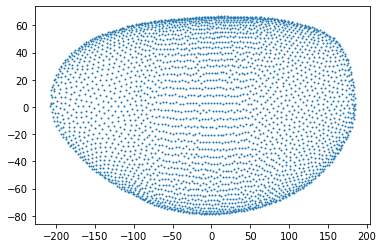

In [82]:
%matplotlib inline
plt.figure()
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.show()
plt.close()


We can visualize all the position for which Z=1

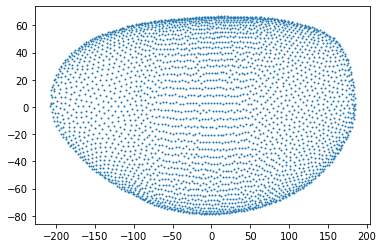

In [83]:
%matplotlib inline
plt.figure()
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.show()
plt.close()



## Alternative tissue spaces
If you do not know the cellular locations of your tissue, you can create them. novoSpaRc has  two functions that enable to construct them quickly.
### case 2: you know the shape of your tissue
he function *create_target_space_from_image* creates a target space by using a user-generated image. The image has to be a black shape drawn onto a white background. You can do it in Fiji for instance.

In [84]:
tissue_path = '/Users/lnoiret/Google Drive/YohannsBellaiche/single_cell/code/novosparc-master/novosparc/datasets/tissue_example.png'
locations2   = novosparc.geometry.create_target_space_from_image(tissue_path)
print(locations2[:3,])

[[148 379]
 [148 381]
 [148 383]]


This will probably create a very large number of locations, so it's better to subsample them.

In [85]:
print ('dimension of original tissue space:', locations2.shape)
locations2     = locations2[np.random.choice(locations2.shape[0], 2000), :]
print ('dimension of downsampled tissue space:', locations2.shape[0])

dimension of original tissue space: (125058, 2)
dimension of downsampled tissue space: 2000


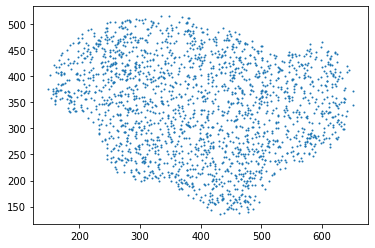

In [86]:
plt.figure()
plt.scatter(locations2[:, 0], locations2[:, 1],s=1)
plt.show()
plt.close()

### case 3 : you assume that your tissue is a rectangle
The function *construct_target_grid* can be used to construct a basic rectangular grid as target space. The only parameter is the total number of cellular locations on the target grid.

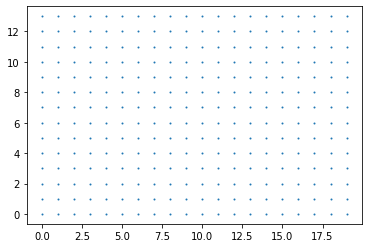

In [87]:
locations3 = novosparc.geometry.construct_target_grid(500)
plt.figure()
plt.scatter(locations3[:, 0], locations3[:, 1], s=1)
plt.show()
plt.close()



# 3. Predict the spatial transcriptome

## Predict the spatial transcriptome (without landmark genes)

Once you have defined the cellular locations, you can create a "tissue object" that will contain the predited spatial transcriptome.

In [73]:
# create a tissue object, the results will be saved in the directory "outputs"
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations, output_folder='outputs') 

**Principle of novosparc** (if no landmarks genes are provided) : 

1. construct a k-nearest neighbors (knn) graph 

    * for the physical space (cellular location) : calculate the (euclidian) distance matrix between the  locations, then for each location only keep the k-nearest neighbours (the value k is set by *num_neighbors_s*). 
    * for the expression space (single cells) : calculate the distance (correlation)  matrix between the  each cells, then for each location only keep the k-nearest neighbours (the value k is set by *num_neighbors_t*)

2. Novosparc compute the shortest path lengths for each pair of cells, resulting in graph-based distance matrices for cells and for locations. 

3) To to match the N single cells to the M position using these graphs, the algorithm try to minimize the discrepancy between the pair-wise graph-based distances in expression space and in physical space


In [89]:
tissue.setup_reconstruction(num_neighbors_s = 5, num_neighbors_t = 5)   # compute the knn graphs                         


Setting up for reconstruction ... done ( 3.58 seconds )


Now we can reconstruct our tissue. The alpha_linear parameter controls the contribution of the two branches in novoSpaRc: alpha_linear=0 means that no prior information is available

In [90]:
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 1297 cells and 3039 locations ... 
It.  |Err         
-------------------
    0|3.145352e-04|


We store the spatial gene expression matrix (sDGE) for the highly variable genes across all locations in a new variable

In [91]:
sdge_hvg = tissue.sdge


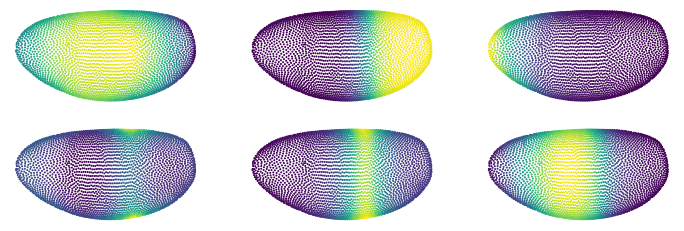

In [92]:
plt.figure(figsize=(12,4))
plt.subplot(231)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge_hvg[np.argwhere(hvg == 'ftz')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(232)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge_hvg[np.argwhere(hvg == 'twi')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(233)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge_hvg[np.argwhere(hvg == 'zen')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(234)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge_hvg[np.argwhere(hvg == 'ImpE2')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(235)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge_hvg[np.argwhere(hvg == 'sim')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(236)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge_hvg[np.argwhere(hvg == 'pyr')[0], :].flatten(), s=1)
plt.axis('off')
plt.show()
plt.close()



This reconstruction has been realised without priori information. We can greatly improve the prediction by adding landmark genes
## Predict the spatial transcriptome (with landmark genes)
### Import landmark genes

In [173]:
insitu_genes = np.genfromtxt(datafile_atlas, usecols=range(84), dtype='str', max_rows=1)
atlas_matrix = np.loadtxt(datafile_atlas, usecols=range(84), skiprows=1)

We are going to create a new tissue object 

In [174]:
tissue_with_markers = novosparc.cm.Tissue(dataset=dataset, locations=locations)



In [175]:
print(dataset.shape,locations.shape,atlas_matrix.shape)

(1297, 476) (3039, 2) (3039, 84)


In [176]:
insitu_genes

array(['aay', 'Ama', 'Ance', 'Antp', 'apt', 'Blimp-1', 'bmm', 'bowl',
       'brk', 'Btk29A', 'bun', 'cad', 'CenG1A', 'CG10479', 'CG11208',
       'CG14427', 'CG17724', 'CG17786', 'CG43394', 'CG8147', 'cnc',
       'croc', 'Cyp310a1', 'D', 'dan', 'danr', 'Dfd', 'disco', 'Doc2',
       'Doc3', 'dpn', 'edl', 'ems', 'erm', 'Esp', 'E(spl)m5-HLH', 'eve',
       'exex', 'fj', 'fkh', 'ftz', 'gk', 'gt', 'h', 'hb', 'hkb', 'htl',
       'Ilp4', 'ImpE2', 'ImpL2', 'ken', 'kni', 'knrl', 'Kr', 'lok',
       'Mdr49', 'Mes2', 'MESR3', 'mfas', 'Nek2', 'NetA', 'noc', 'nub',
       'numb', 'oc', 'odd', 'peb', 'prd', 'pxb', 'rau', 'rho', 'run',
       'sna', 'srp', 'tkv', 'tll', 'toc', 'Traf4', 'trn', 'tsh', 'twi',
       'zen', 'zen2', 'zfh1'], dtype='<U12')

First, we find the indices of the marker genes in the scRNAseq dataset

In [177]:
insitu_genes = insitu_genes[2:5]
atlas_matrix = atlas_matrix[:,2:5]

In [178]:
insitu_genes

array(['Ance', 'Antp', 'apt'], dtype='<U12')

In [179]:
gene_names = tissue_with_markers.gene_names
markers_in_sc = np.array([], dtype='int') # indice marker dans table sc

for marker in insitu_genes:
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])

print(markers_in_sc.shape )
print(gene_names[markers_in_sc])

(3,)
['Ance' 'Antp' 'apt']


The first steps of the reconstruction are the same, except that know the softwar also try to optimize the postion using the landmark genes 

In [180]:
tissue_with_markers.setup_reconstruction(markers_to_use=markers_in_sc, insitu_matrix=atlas_matrix,num_neighbors_s = 5, num_neighbors_t = 5)   # compute the knn graphs                         


Setting up for reconstruction ... done ( 3.54 seconds )


In [181]:
num_markers = markers_in_sc.shape[0]
markers_in_sc.shape


(3,)

In [182]:

alpha_linear = 0.5
tissue_with_markers.reconstruct(alpha_linear=0.5, epsilon=5e-3)

Reconstructing spatial information with 3 markers: 1297 cells and 3039 locations ... 
It.  |Err         
-------------------
    0|1.578392e-03|




Compute the sDGE and plot spatial gene expression patterns


In [183]:
sdge_hvg2 = tissue_with_markers.sdge 

# JE n'ai pas regardé après ce point : j'ai fait ce qui suit il y a un an ! 


Compare the raw expression and the predited expression

In [ ]:
g ='ftz'
c=insitu_matrix[ :,np.argwhere(insitu_genes == g)[0]].flatten()
d=sdge[np.argwhere(gene_names == g)[0], :].flatten()
plt.scatter(c,d)
print ( pearsonr(c,d) )


# 5. Write data to disk for further use 
output filename : sdge_1297_cells_3039_locations


6. Plot gene expression 

In [199]:
def plot_gene_patterns(locations, sdge, genes, folder, gene_names, num_cells,
                       size_x=16, size_y=12, pt_size=20, cmap='viridis', prefix=''):
    """Plots gene expression patterns on the target space.

    Keyword arguments:
    locations  -- the locations of the target space
    sdge       -- the sdge computed from the reconstruction
    genes      -- the genes to plot as a list: ['gene1', 'geme2', ...]
    folder     -- the folder to save the .png output.
    gene_names -- an numpy array of all genes appearing in the sdge
    num_cells  -- the number of cells used for the reconstruction
    size_x     -- the width of the resulting figure
    size_y     -- the height of the resulting figure
    pt_size    -- the size of the points
    cmap       -- custom colormap. Only used for 2D reconstructions
    """
    num_rows = int(round(np.sqrt(len(genes))))
    plt.figure(figsize=(size_x, size_y))
    
    idx = 1
    for gene in genes:
        plt.subplot(num_rows, np.ceil(len(genes)/num_rows), idx)
        plt.scatter(locations[:, 0], locations[:, 1], 
                        c=sdge[np.argwhere(gene_names == gene), :].flatten(),
                        s=pt_size, cmap=cmap)
        plt.title(gene)
        plt.axis('off')
        idx += 1
            
    plt.tight_layout()
    plt.savefig(os.path.join(folder, prefix + str(num_cells) + '_cells_'
        + str(locations.shape[0]) + '_locations' +'.png'))
    plt.close()
    


In [200]:
gene_list_to_plot = ['ftz', 'twi', 'ImpE2','aay']
plot_gene_patterns(locations, sdge, gene_list_to_plot,
                                    folder=output_folder,
                                    gene_names=gene_names, num_cells=num_cells,prefix='fig')


# 7. Correlate results with BDTNP #
  

In [242]:
L=[]
with open(os.path.join(output_folder, 'results.txt'), 'a') as f:
    #f.write('number_cells,,number_markers,' +  ','.join(insitu_genes) + '\n')
    #f.write(str(num_cells) + ',' + str(num_markers) + ',')
    for i in insitu_genes:
        #print(i)
        c = insitu_matrix[ :,np.argwhere(insitu_genes == i)[0]].flatten()
        d = sdge[np.argwhere(gene_names == i)[0], :].flatten()
        L.append(round(pearsonr(c,d)[0], 2) )
        f.write(str(round(pearsonr(c,d)[0], 2)) + ',')
        

In [137]:
novosparc.pl.plot_gene_patterns(locations, sdge, important_gene_names,
                                    folder=output_folder,
                                    gene_names=gene_names, num_cells=num_cells, prefix='_spatially_important_')
